In [ ]:
!pip install LightAutoML -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.5/412.5 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.3 MB/s eta 0:00:00


# EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import gc

warnings.filterwarnings('ignore')

# Загрузка данных
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Базовый анализ
print("\n Размеры датасетов ")
print(f"Train: {train_data.shape}")
print(f"Test: {test_data.shape}")

print("\n Типы данных ")
print(train_data.dtypes)

print("\n Пропущенные значения ")
print(train_data.isnull().sum())

print("\n Статистики числовых признаков")
print(train_data.describe())



 Размеры датасетов 
Train: (593994, 13)
Test: (254569, 12)

 Типы данных 
id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
loan_paid_back          float64
dtype: object

 Пропущенные значения 
id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

 Статистики числовых признаков
                  id  annual_income  debt_to_income_ratio   credit_score  \
count  59399


 Распределение целевой переменной
loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64


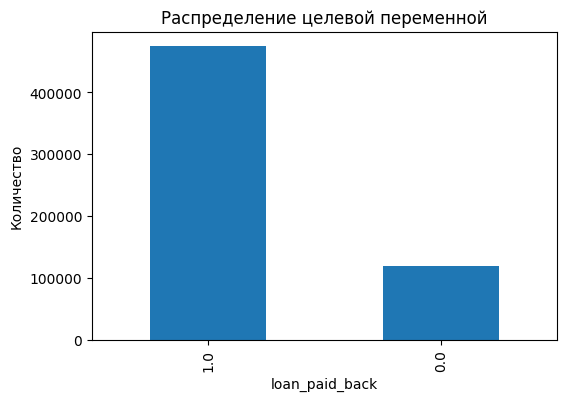

In [ ]:
# Анализ целевой переменной
print("\n Распределение целевой переменной")
print(train_data['loan_paid_back'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
train_data['loan_paid_back'].value_counts().plot(kind='bar')
plt.title('Распределение целевой переменной')
plt.xlabel('loan_paid_back')
plt.ylabel('Количество')
plt.show()


 Анализ числовых признаков 


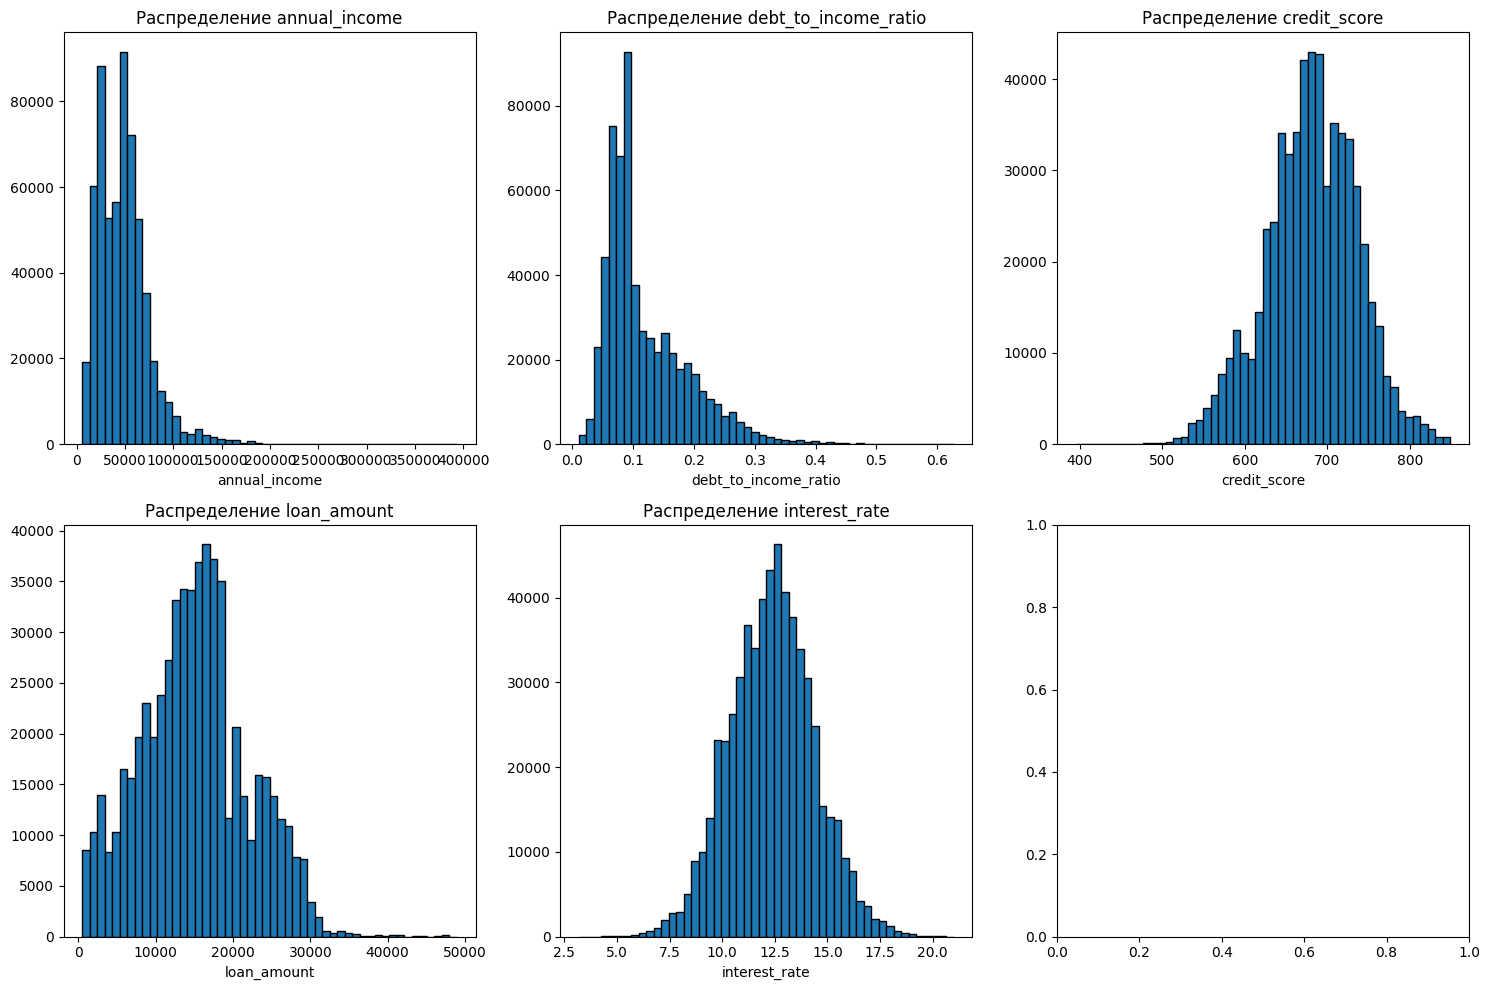


 Корреляция числовых признаков с целевой 
loan_paid_back          1.000000
credit_score            0.234560
annual_income           0.006326
loan_amount            -0.003762
interest_rate          -0.131184
debt_to_income_ratio   -0.335680
Name: loan_paid_back, dtype: float64


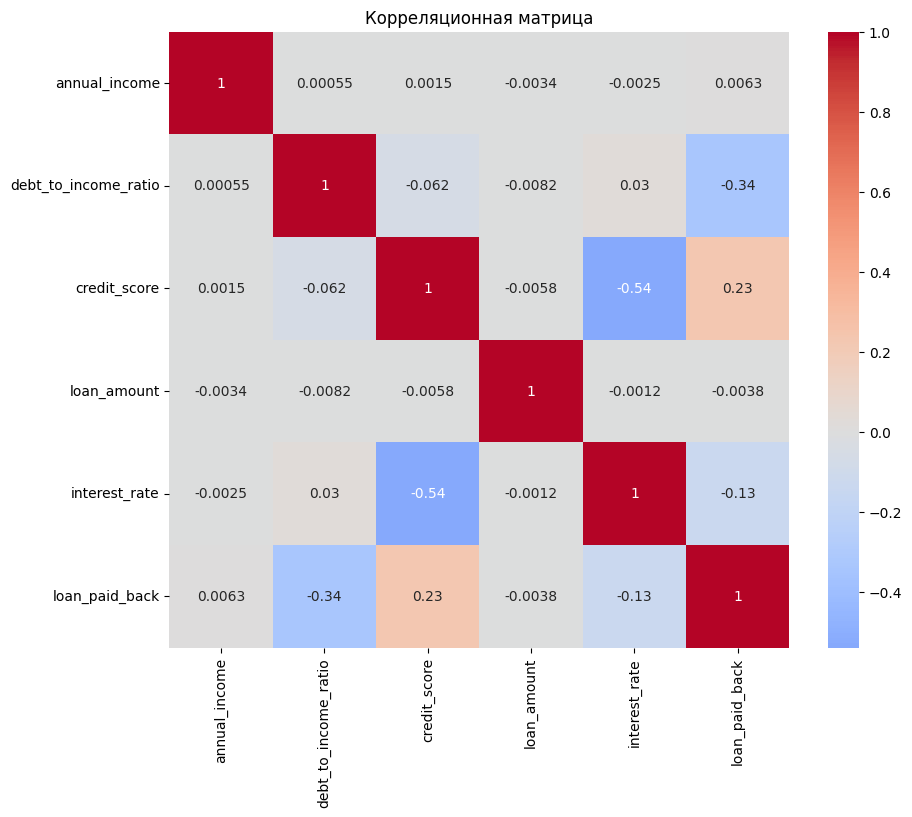

In [ ]:
# Определяем признаки
numeric_cols = ['annual_income', 'debt_to_income_ratio', 'credit_score',
                'loan_amount', 'interest_rate']
categorical_cols = ['gender', 'marital_status', 'education_level',
                    'employment_status', 'loan_purpose', 'grade_subgrade']

# Распределения числовых признаков
print("\n Анализ числовых признаков ")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for idx, col in enumerate(numeric_cols):
    axes[idx].hist(train_data[col], bins=50, edgecolor='black')
    axes[idx].set_title(f'Распределение {col}')
    axes[idx].set_xlabel(col)
plt.tight_layout()
plt.show()

# Корреляция с целевой переменной
print("\n Корреляция числовых признаков с целевой ")
correlations = train_data[numeric_cols + ['loan_paid_back']].corr()['loan_paid_back'].sort_values(ascending=False)
print(correlations)

# Тепловая карта корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numeric_cols + ['loan_paid_back']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.show()


## Выводы
   - debt_to_income_ratio: -0.336 (сильная отрицательная)
   - credit_score: 0.235 (умеренная положительная)
   - annual_income и loan_amount: слабая корреляция


 Анализ категориальных признаков 

--- gender ---
gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64

Средняя вероятность возврата кредита по gender:
gender
Female    0.801708
Male      0.795752
Other     0.795333
Name: loan_paid_back, dtype: float64

--- marital_status ---
marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64

Средняя вероятность возврата кредита по marital_status:
marital_status
Married     0.799144
Single      0.798873
Divorced    0.796640
Widowed     0.789848
Name: loan_paid_back, dtype: float64

--- education_level ---
education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64

Средняя вероятность возврата кредита по education_level:
education_level
PhD            0.830067
High School    0.809698
Other          0.802789
Master's       0.802346
Bachelor's     0.788892
Name: loan

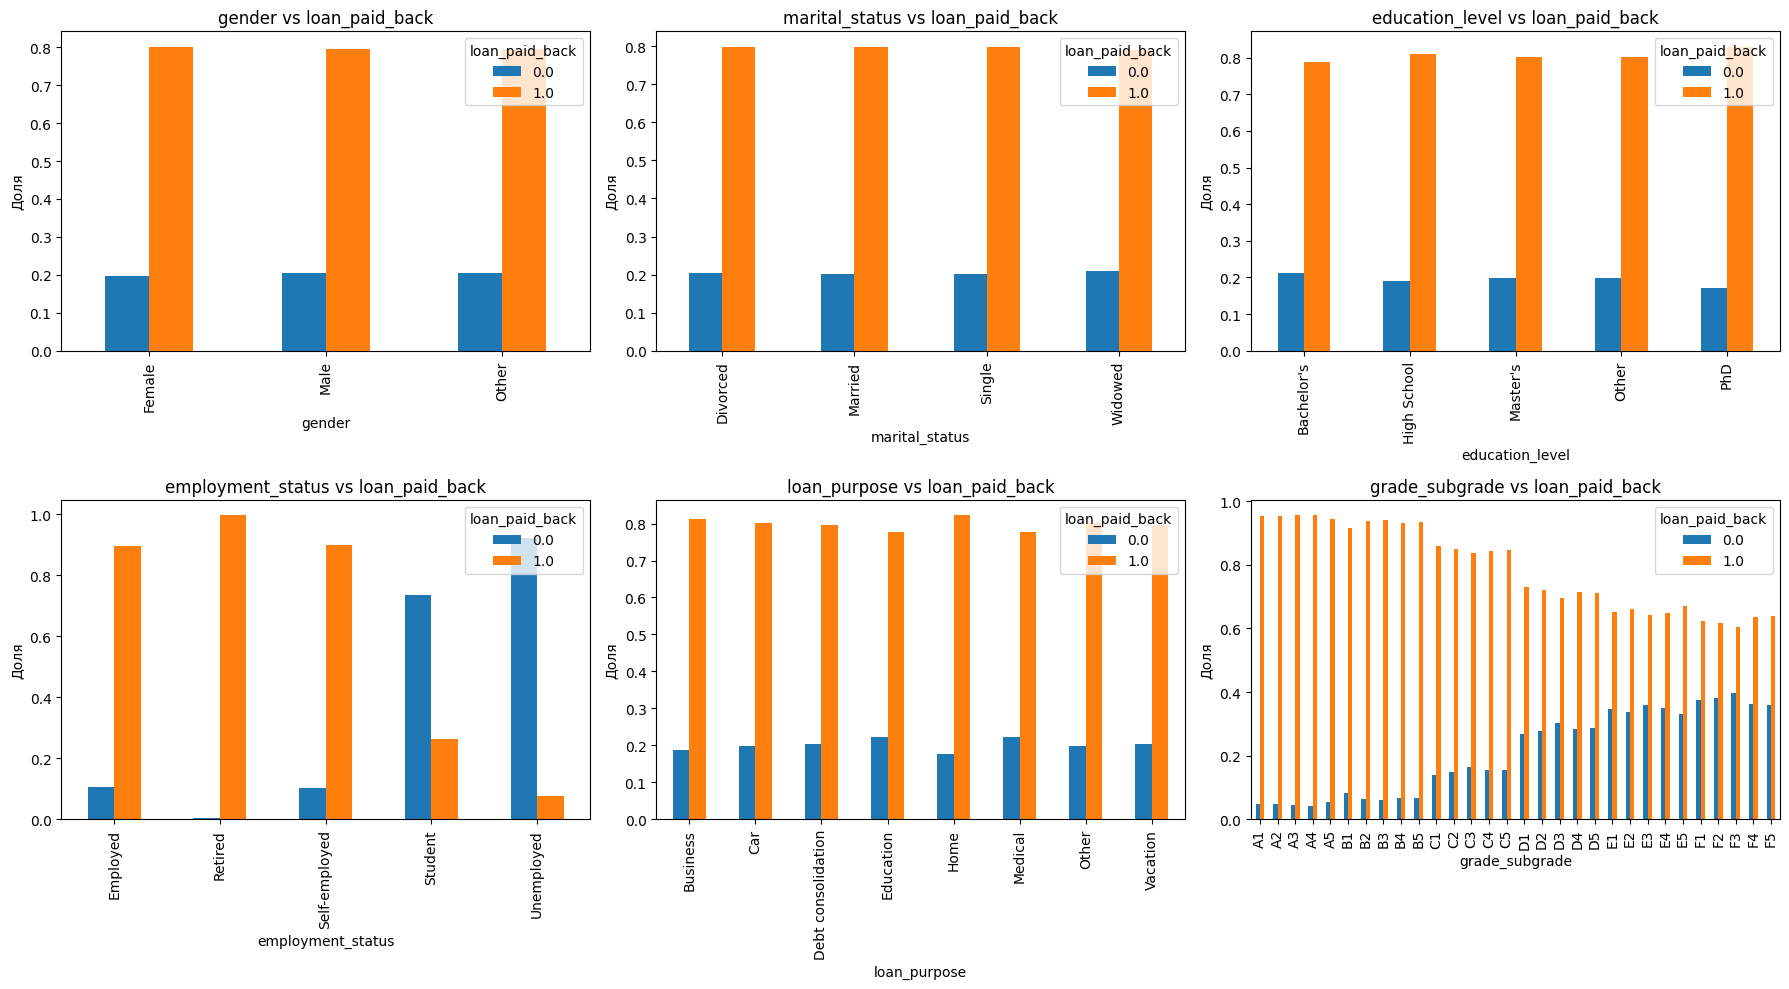

In [ ]:
# Анализ категориальных признаков
print("\n Анализ категориальных признаков ")
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(train_data[col].value_counts())

    print(f"\nСредняя вероятность возврата кредита по {col}:")
    probs = train_data.groupby(col)['loan_paid_back'].mean().sort_values(ascending=False)
    print(probs)

# Визуализация категориальных признаков
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()
for idx, col in enumerate(categorical_cols):
    pd.crosstab(train_data[col], train_data['loan_paid_back'],
                normalize='index').plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f'{col} vs loan_paid_back')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Доля')
    axes[idx].legend(title='loan_paid_back')
plt.tight_layout()
plt.show()

## Ключевые находки из EDA

1. **`employment_status` — самый сильный признак**
   - Retired: **99.7%**
   - Unemployed: **7.8%**
Огромная разница в вероятности возврата

2. **`grade_subgrade` — чёткая градация внутри буквенных классов**
   - Пример: A1/A5 (**95.2%/94.5%**)
   - Внутри каждой буквы есть выраженный паттерн по цифре.

3. **Числовые признаки слабокоррелированы**
   - Значит, модель выигрывает от *взаимодействий* (feature crosses).

4. **`education_level`**
   - PhD: **83%**
   - Bachelor’s: **78.9%**
Признак информативный, но не доминирующий.

5. **`loan_purpose`**
   - Home: **82.3%**
   - Education: **77.7%**
Существенные различия между категориями.



 Выбросы (IQR метод) 
annual_income: 15917 выбросов (2.68%)
debt_to_income_ratio: 17556 выбросов (2.96%)
credit_score: 5901 выбросов (0.99%)
loan_amount: 2902 выбросов (0.49%)
interest_rate: 5136 выбросов (0.86%)


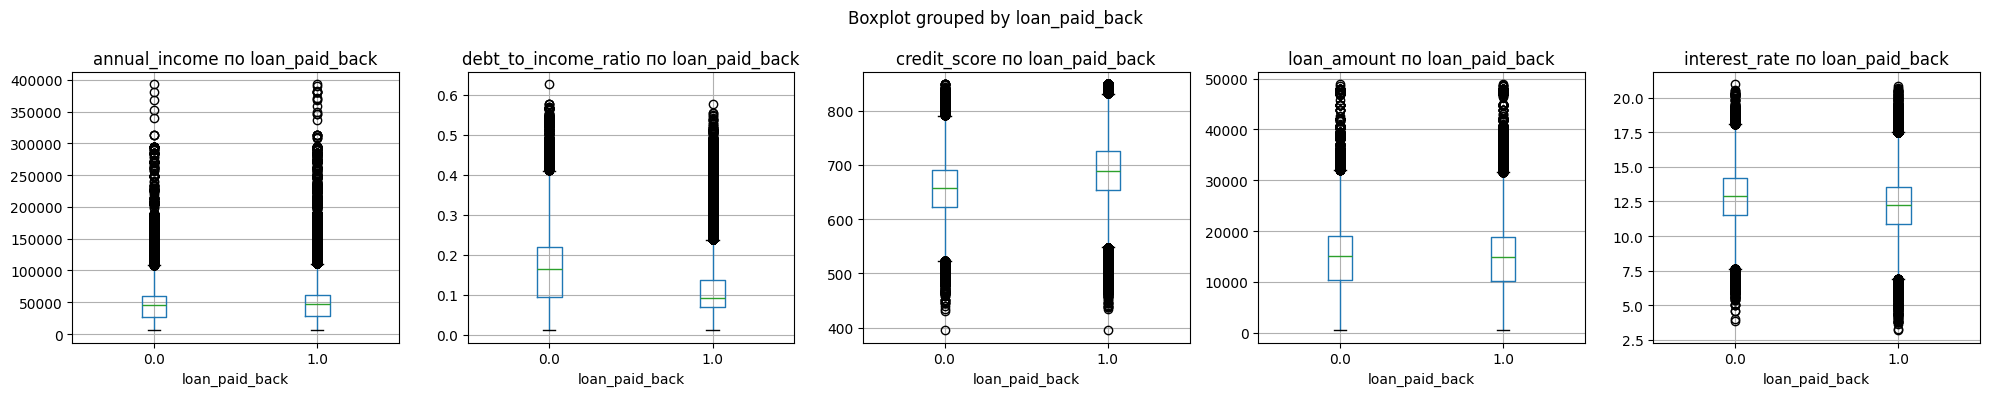

In [ ]:
# Анализ выбросов
print("\n Выбросы (IQR метод) ")
for col in numeric_cols:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((train_data[col] < (Q1 - 1.5 * IQR)) |
                (train_data[col] > (Q3 + 1.5 * IQR))).sum()
    print(f"{col}: {outliers} выбросов ({outliers/len(train_data)*100:.2f}%)")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, col in enumerate(numeric_cols):
    train_data.boxplot(column=col, by='loan_paid_back', ax=axes[idx])
    axes[idx].set_title(f'{col} по loan_paid_back')
plt.tight_layout()
plt.show()

# FEATURE ENGINEERING

## Обоснования для создаваемых признаков


### 1. Извлечение `grade_digit` из `grade_subgrade`
- Внутри каждой буквенной категории (A-F) есть выраженная градация по цифре.
- Пример: A1/A5 соответствует снижению вероятности возврата (**95.2%/94.5%**).
- Цифра несёт собственную информативность и должна использоваться отдельно.


### 2. Взаимодействия числовых признаков
Корреляции между числовыми признаками низкие, поэтому отдельные фичи малоинформативны.  
Комбинации улучшают модель за счёт доменных зависимостей.

- **income_to_loan_ratio** - способность заёмщика погасить займ.  
- **loan_to_income_ratio** - относительный размер кредита.  
- **debt_times_rate** - комплексная долговая нагрузка (долги x ставка).  
- **income_times_credit** - интегральная «надёжность» (доход x кредитный рейтинг).  
- **monthly_payment_estimate / payment_to_income** - реальная месячная нагрузка.


### 3. Усиление `employment_status` (ключевой признак)
- Разница между категориями экстремально высока:  
  - Retired: **99.7%**  
  - Unemployed: **7.8%**  
- Создаются статистики по числовым признакам внутри каждой категории занятости:
  - Среднее  
  - Отклонение  
  - Процент отклонения  
Это позволяет выделить финансовые профили для каждой группы занятости.


### 4. Групповая статистика по категориальным признакам
Используется стандартная техника для извлечения скрытых паттернов внутри категорий.

**По `grade_subgrade`:** сильная связь (60–95%)  
- mean  
- std  
- разница от среднего  

**По `loan_purpose`:** (77–82%)  
- mean и разница для ключевых числовых признаков  

**По `education_level`:** (78–83%)  
- mean для дохода и кредитного рейтинга  


### 5. Комбинации категорий
Создаются взаимодействия между важными категориальными переменными.

- `employment_status + education_level`  
- `employment_status + marital_status`  
- `grade_subgrade + loan_purpose`  
- `education_level + loan_purpose`  

Цель - уловить различия внутри комбинаций (например, «Retired + PhD» не то же самое, что «Retired + High School»).

### 6. Бинарные флаги
- **high_credit_score ≥ 720** - высокий кредитный рейтинг.  
- **low_debt_ratio ≤ 0.1** - низкая долговая нагрузка.  
- **high_income ≥ 60,000** - устойчивый доход.  
- **small_loan ≤ 10,000** - низкий размер кредита.  
- **low_interest ≤ 11%** - выгодная ставка.

Флаги помогают модели выделять важные пороговые состояния.



In [ ]:
# Перезагружаем данные для FE
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Сохраняем ID и target
test_ids = test['id'].copy()
target = train['loan_paid_back'].copy()

# Удаляем служебные колонки
train = train.drop(columns=['id', 'loan_paid_back'])
test = test.drop(columns=['id'])

NUMS = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
CATS = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']

print("\nСоздаём признаки на основе инсайтов из EDA")

# ПРИЗНАК 1: grade_digit
print("\nПРИЗНАК 1: Извлечение цифры из grade_subgrade")
train['grade_digit'] = train['grade_subgrade'].str[1].astype('int8')
test['grade_digit'] = test['grade_subgrade'].str[1].astype('int8')

train['grade_letter'] = train['grade_subgrade'].str[0]
test['grade_letter'] = test['grade_subgrade'].str[0]

# ПРИЗНАК 2: Числовые взаимодействия
print("\nПРИЗНАК 2: Взаимодействия числовых признаков")

# Платёжеспособность
train['income_to_loan_ratio'] = train['annual_income'] / (train['loan_amount'] + 1)
test['income_to_loan_ratio'] = test['annual_income'] / (test['loan_amount'] + 1)
print("- income_to_loan_ratio: способность погасить займ")

# Долговая нагрузка
train['loan_to_income_ratio'] = train['loan_amount'] / (train['annual_income'] + 1)
test['loan_to_income_ratio'] = test['loan_amount'] / (test['annual_income'] + 1)
print("- loan_to_income_ratio: размер займа относительно дохода")

# Совокупный риск
train['debt_times_rate'] = train['debt_to_income_ratio'] * train['interest_rate']
test['debt_times_rate'] = test['debt_to_income_ratio'] * test['interest_rate']
print("- debt_times_rate: комплексная оценка долговой нагрузки")

# Кредитоспособность
train['income_times_credit'] = train['annual_income'] * train['credit_score'] / 1000000
test['income_times_credit'] = test['annual_income'] * test['credit_score'] / 1000000
print("- income_times_credit: общая финансовая надёжность")

# Месячный платёж и нагрузка
train['monthly_payment_estimate'] = (train['loan_amount'] * train['interest_rate'] / 100) / 12
test['monthly_payment_estimate'] = (test['loan_amount'] * test['interest_rate'] / 100) / 12

train['payment_to_income'] = train['monthly_payment_estimate'] / (train['annual_income'] / 12 + 1)
test['payment_to_income'] = test['monthly_payment_estimate'] / (test['annual_income'] / 12 + 1)
print("- payment_to_income: реальная месячная нагрузка на бюджет")

# ПРИЗНАК 3: employment_status
print("\nПРИЗНАК 3: Фокус на employment_status")

# Групповая статистика по employment
for num_col in NUMS:
    group_mean = train.groupby('employment_status')[num_col].mean()
    train[f'{num_col}_mean_by_employment'] = train['employment_status'].map(group_mean)
    test[f'{num_col}_mean_by_employment'] = test['employment_status'].map(group_mean)

    train[f'{num_col}_diff_from_employment'] = train[num_col] - train[f'{num_col}_mean_by_employment']
    test[f'{num_col}_diff_from_employment'] = test[num_col] - test[f'{num_col}_mean_by_employment']

    train[f'{num_col}_pct_from_employment'] = train[f'{num_col}_diff_from_employment'] / (train[f'{num_col}_mean_by_employment'] + 1)
    test[f'{num_col}_pct_from_employment'] = test[f'{num_col}_diff_from_employment'] / (test[f'{num_col}_mean_by_employment'] + 1)

print("   - Созданы среднее, отклонение и % отклонение для каждого числового признака")

# Комбинации employment с категориями
for cat_col in ['education_level', 'marital_status', 'loan_purpose']:
    name = f'employment_{cat_col}'
    train[name] = train['employment_status'].astype(str) + '_' + train[cat_col].astype(str)
    test[name] = test['employment_status'].astype(str) + '_' + test[cat_col].astype(str)
print("   - Комбинации employment с education, marital_status, loan_purpose")

# ПРИЗНАК 4: Группировки по категориям
print("\nПРИЗНАК 4: Групповая статистика по категориям")
print("   Обоснование: стандартная практика для извлечения паттернов")

# По grade_subgrade (сильная связь: 60-95%)
for num_col in NUMS:
    group_mean = train.groupby('grade_subgrade')[num_col].mean()
    group_std = train.groupby('grade_subgrade')[num_col].std()

    train[f'{num_col}_mean_by_grade'] = train['grade_subgrade'].map(group_mean)
    test[f'{num_col}_mean_by_grade'] = test['grade_subgrade'].map(group_mean)

    train[f'{num_col}_std_by_grade'] = train['grade_subgrade'].map(group_std)
    test[f'{num_col}_std_by_grade'] = test['grade_subgrade'].map(group_std)

    train[f'{num_col}_diff_from_grade'] = train[num_col] - train[f'{num_col}_mean_by_grade']
    test[f'{num_col}_diff_from_grade'] = test[num_col] - test[f'{num_col}_mean_by_grade']

print("   - Статистика по grade_subgrade (A-F): mean, std, diff")

# По loan_purpose (77-82%)
for num_col in ['annual_income', 'credit_score', 'debt_to_income_ratio']:
    group_mean = train.groupby('loan_purpose')[num_col].mean()
    train[f'{num_col}_mean_by_purpose'] = train['loan_purpose'].map(group_mean)
    test[f'{num_col}_mean_by_purpose'] = test['loan_purpose'].map(group_mean)

    train[f'{num_col}_diff_from_purpose'] = train[num_col] - train[f'{num_col}_mean_by_purpose']
    test[f'{num_col}_diff_from_purpose'] = test[num_col] - test[f'{num_col}_mean_by_purpose']

print("- Статистика по loan_purpose")

# По education_level (78-83%)
for num_col in ['annual_income', 'credit_score']:
    group_mean = train.groupby('education_level')[num_col].mean()
    train[f'{num_col}_mean_by_education'] = train['education_level'].map(group_mean)
    test[f'{num_col}_mean_by_education'] = test['education_level'].map(group_mean)

print("- Статистика по education_level")

# ПРИЗНАК 5: Комбинации категорий
print("\nПРИЗНАК 5: Комбинации категориальных признаков")

important_cat_pairs = [
    ('employment_status', 'education_level'),
    ('employment_status', 'marital_status'),
    ('grade_subgrade', 'loan_purpose'),
    ('education_level', 'loan_purpose'),
]

for col1, col2 in important_cat_pairs:
    name = f'{col1}_{col2}_combo'
    train[name] = train[col1].astype(str) + '_' + train[col2].astype(str)
    test[name] = test[col1].astype(str) + '_' + test[col2].astype(str)

print(f"- Создано {len(important_cat_pairs)} комбинаций")


# ПРИЗНАК 6: Флаги
print("\nПРИЗНАК 6: Бинарные флаги")

train['high_credit_score'] = (train['credit_score'] >= 720).astype('int8')
test['high_credit_score'] = (test['credit_score'] >= 720).astype('int8')

train['low_debt_ratio'] = (train['debt_to_income_ratio'] <= 0.1).astype('int8')
test['low_debt_ratio'] = (test['debt_to_income_ratio'] <= 0.1).astype('int8')

train['high_income'] = (train['annual_income'] >= 60000).astype('int8')
test['high_income'] = (test['annual_income'] >= 60000).astype('int8')

train['small_loan'] = (train['loan_amount'] <= 10000).astype('int8')
test['small_loan'] = (test['loan_amount'] <= 10000).astype('int8')

train['low_interest'] = (train['interest_rate'] <= 11).astype('int8')
test['low_interest'] = (test['interest_rate'] <= 11).astype('int8')

print(f"\nFeature Engineering завершён!")
print(f"Было признаков: 11")
print(f"Стало признаков: {train.shape[1]}")
print(f"Создано новых: {train.shape[1] - 11}")

# Сохраняем для последующего использования
train_fe = train.copy()
test_fe = test.copy()



Создаём признаки на основе инсайтов из EDA

ПРИЗНАК 1: Извлечение цифры из grade_subgrade

ПРИЗНАК 2: Взаимодействия числовых признаков
- income_to_loan_ratio: способность погасить займ
- loan_to_income_ratio: размер займа относительно дохода
- debt_times_rate: комплексная оценка долговой нагрузки
- income_times_credit: общая финансовая надёжность
- payment_to_income: реальная месячная нагрузка на бюджет

ПРИЗНАК 3: Фокус на employment_status
   - Созданы среднее, отклонение и % отклонение для каждого числового признака
   - Комбинации employment с education, marital_status, loan_purpose

ПРИЗНАК 4: Групповая статистика по категориям
   Обоснование: стандартная практика для извлечения паттернов
   - Статистика по grade_subgrade (A-F): mean, std, diff
- Статистика по loan_purpose
- Статистика по education_level

ПРИЗНАК 5: Комбинации категориальных признаков
- Создано 4 комбинаций

ПРИЗНАК 6: Бинарные флаги

Feature Engineering завершён!
Было признаков: 11
Стало признаков: 69
Создано н

# LightAutoML (baseline)

In [ ]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# Подготовка данных для AutoML
X_train_automl = pd.read_csv('train.csv')
X_test_automl = pd.read_csv('test.csv')

test_ids = X_test_automl['id'].copy()
target = X_train_automl['loan_paid_back'].copy()

# Удаляем служебные колонки
train = X_train_automl.drop(columns=['id', 'loan_paid_back'])
test =  X_test_automl.drop(columns=['id'])

# AutoML работает лучше с исходными данными
X_train_automl = X_train_automl.assign(loan_paid_back=target)

print("\nОбучение LightAutoML")

task = Task('binary')
automl = TabularAutoML(
    task=task,
    timeout=3600,
    cpu_limit=4,
    reader_params={
        'n_jobs': 4,
        'cv': 5,
        'random_state': 42,
    }
)

# Обучение
oof_pred_automl = automl.fit_predict(
    X_train_automl,
    roles={'target': 'loan_paid_back'}
)

# Предсказание
test_pred_automl = automl.predict(X_test_automl)
pred_proba_automl = test_pred_automl.data.flatten()

from sklearn.metrics import roc_auc_score
automl_cv_auc = roc_auc_score(target, oof_pred_automl.data.flatten())

print(f"\nLightAutoML CV AUC: {automl_cv_auc:.5f}")

# Сохранение submission
submission = pd.DataFrame({
    'id': test_ids,
    'loan_paid_back': pred_proba_automl
})

submission.to_csv('submission_automl.csv', index=False)

print("\nФайл submission.csv успешно сохранён!")
print(submission.head())

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: binary

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 4 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (593994, 13)




Обучение LightAutoML


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3588.06 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2, 3], 'embed_sizes': array([ 6, 31,  9,  5], dtype=int32), 'data_size': 22}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.920037407971417
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.9211852449075897
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.9214482556460268
INFO3:lightautoml.


LightAutoML CV AUC: 0.92237

Файл submission.csv успешно сохранён!
       id  loan_paid_back
0  593994        0.907680
1  593995        0.956158
2  593996        0.417844
3  593997        0.919785
4  593998        0.954089


## Результаты
- Private Score 0.92584
- Public Score 0.92477

# Catboost pipeline

In [ ]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
import optuna
import gc

warnings.filterwarnings('ignore')

# Данные
train_data = train_fe.copy()
test_data = test_fe.copy()
y = target.copy().reset_index(drop=True)
test_ids = test_ids.copy()

# Категориальные признаки
cat_cols = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Категориальные признаки: {cat_cols}")

# Индексы категориальных колонок
cat_feature_indices = [train_data.columns.get_loc(c) for c in cat_cols]

# для воспроизводимости
RND = 42

# функция Optuna
def objective(trial):

    # Только поддерживаемые GPU лоссы
    loss = trial.suggest_categorical(
        "loss_function",
        ["Logloss", "CrossEntropy"]
    )

    params = {
        "iterations": trial.suggest_int("iterations", 200, 2000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.15),
        "depth": trial.suggest_int("depth", 1, 8),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),
        "bagging_temperature": trial.suggest_uniform("bagging_temperature", 0.0, 1.0),

        # GPU
        "task_type": "GPU",
        "devices": "0",

        "random_seed": RND,
        "loss_function": loss,
        "eval_metric": "AUC",
        "verbose": False
    }

    # Hold-out
    X_tr, X_val, y_tr, y_val = train_test_split(
        train_data, y, test_size=0.2, stratify=y, random_state=RND
    )

    train_pool = Pool(X_tr, label=y_tr, cat_features=cat_feature_indices)
    val_pool = Pool(X_val, label=y_val, cat_features=cat_feature_indices)

    model = CatBoostClassifier(**params)

    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        early_stopping_rounds=50,
        verbose=False
    )

    pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, pred)

    del model, X_tr, X_val, y_tr, y_val, train_pool, val_pool
    gc.collect()

    return auc


# Оптимизация через optuna

study = optuna.create_study(direction="maximize", study_name="catboost_gpu_opt")
print("\nЗапуск Optuna (GPU)")
study.optimize(objective, n_trials=30, n_jobs=1)

print("\nOptuna завершён")
print(f"Лучший AUC (hold-out): {study.best_value:.5f}")
print("Лучшие параметры:")
print(study.best_params)

best_params = study.best_params.copy()

# GPU-настройки для финального обучения
best_params.update({
    "task_type": "GPU",
    "devices": "0",
    "random_seed": RND,
    "verbose": 200,
    "eval_metric": "AUC"
})


N_FOLDS = 3
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RND)

oof_cat = np.zeros(len(train_data))
pred_cat = np.zeros(len(test_data))

for fold, (tr_idx, val_idx) in enumerate(skf.split(train_data, y)):
    print(f"\n=== Fold {fold + 1}/{N_FOLDS} ===")

    X_tr = train_data.iloc[tr_idx].reset_index(drop=True)
    X_val = train_data.iloc[val_idx].reset_index(drop=True)
    y_tr = y.iloc[tr_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)

    train_pool = Pool(X_tr, label=y_tr, cat_features=cat_feature_indices)
    val_pool = Pool(X_val, label=y_val, cat_features=cat_feature_indices)
    test_pool = Pool(test_data, cat_features=cat_feature_indices)

    model = CatBoostClassifier(**best_params)

    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        early_stopping_rounds=50,
        verbose=200
    )

    oof_cat[val_idx] = model.predict_proba(X_val)[:, 1]
    pred_cat += model.predict_proba(test_data)[:, 1] / N_FOLDS

    fold_auc = roc_auc_score(y_val, oof_cat[val_idx])
    print(f"Fold AUC: {fold_auc:.5f}")

    del X_tr, X_val, y_tr, y_val, train_pool, val_pool, test_pool, model
    gc.collect()

# Полный CV AUC
final_auc = roc_auc_score(y, oof_cat)
print(f"\nИтоговый CV AUC CatBoost: {final_auc:.5f}")


# Сохранение submission
submission = pd.DataFrame({
    "id": test_ids,
    "loan_paid_back": pred_cat
})

submission.to_csv("submission_catboost_gpu_optuna.csv", index=False)
print("\nSubmission сохранён: submission_catboost_gpu_optuna.csv")


[I 2025-12-11 20:39:22,023] A new study created in memory with name: catboost_gpu_opt


Категориальные признаки: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'grade_letter', 'employment_education_level', 'employment_marital_status', 'employment_loan_purpose', 'employment_status_education_level_combo', 'employment_status_marital_status_combo', 'grade_subgrade_loan_purpose_combo', 'education_level_loan_purpose_combo']
CatBoost version: 1.2.8

Запуск Optuna (GPU)


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-11 20:42:28,401] Trial 0 finished with value: 0.9175501110826435 and parameters: {'loss_function': 'Logloss', 'iterations': 1733, 'learning_rate': 0.01273514932958299, 'depth': 7, 'l2_leaf_reg': 0.46520561464476107, 'bagging_temperature': 0.2802152482103478}. Best is trial 0 with value: 0.9175501110826435.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-11 20:45:19,876] Trial 1 finished with value: 0.9150484243080543 and parameters: {'loss_function': 'Logloss', 'iterations': 1901, 'learning_rate': 0.003831509753263433, 'depth': 6, 'l2_leaf_reg': 1.1102045480486629, 'bagging_temperature': 0.4390568159500591}. Best is trial 0 with value: 0.9175501110826435.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-12-11 20:46:20,520] Trial 2 finished with value: 0.9174818336922924 and parameters: {'loss_function': 'Logloss', 'iterations': 737, 'learning_ra


Optuna завершён
Лучший AUC (hold-out): 0.91999
Лучшие параметры:
{'loss_function': 'Logloss', 'iterations': 1234, 'learning_rate': 0.08239100882470687, 'depth': 7, 'l2_leaf_reg': 1.831066651742579, 'bagging_temperature': 0.18603106703265415}

=== Fold 1/3 ===


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9049505	best: 0.9049505 (0)	total: 112ms	remaining: 2m 18s
200:	test: 0.9181073	best: 0.9181073 (200)	total: 17.3s	remaining: 1m 28s
400:	test: 0.9195079	best: 0.9195079 (400)	total: 33.9s	remaining: 1m 10s
600:	test: 0.9201159	best: 0.9201159 (600)	total: 51s	remaining: 53.8s
800:	test: 0.9204982	best: 0.9205081 (787)	total: 1m 8s	remaining: 36.8s
1000:	test: 0.9208233	best: 0.9208252 (986)	total: 1m 24s	remaining: 19.7s
1200:	test: 0.9209250	best: 0.9209278 (1199)	total: 1m 42s	remaining: 2.81s
1233:	test: 0.9209318	best: 0.9209355 (1227)	total: 1m 45s	remaining: 0us
bestTest = 0.9209355116
bestIteration = 1227
Shrink model to first 1228 iterations.
Fold AUC: 0.92094

=== Fold 2/3 ===


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9020538	best: 0.9020538 (0)	total: 112ms	remaining: 2m 18s
200:	test: 0.9163269	best: 0.9163269 (200)	total: 16.7s	remaining: 1m 26s
400:	test: 0.9178674	best: 0.9178686 (399)	total: 33.7s	remaining: 1m 9s
600:	test: 0.9184692	best: 0.9184768 (593)	total: 51.7s	remaining: 54.4s
800:	test: 0.9187582	best: 0.9187597 (795)	total: 1m 8s	remaining: 37s
1000:	test: 0.9189578	best: 0.9189625 (998)	total: 1m 26s	remaining: 20s
bestTest = 0.9191297293
bestIteration = 1113
Shrink model to first 1114 iterations.
Fold AUC: 0.91913

=== Fold 3/3 ===


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9051097	best: 0.9051097 (0)	total: 156ms	remaining: 3m 11s
200:	test: 0.9172566	best: 0.9172566 (200)	total: 16.8s	remaining: 1m 26s
400:	test: 0.9186828	best: 0.9186902 (398)	total: 33.4s	remaining: 1m 9s
600:	test: 0.9191728	best: 0.9191792 (597)	total: 50.9s	remaining: 53.6s
800:	test: 0.9195902	best: 0.9195902 (800)	total: 1m 7s	remaining: 36.5s
1000:	test: 0.9198743	best: 0.9198826 (994)	total: 1m 24s	remaining: 19.8s
bestTest = 0.919968605
bestIteration = 1063
Shrink model to first 1064 iterations.
Fold AUC: 0.91997

Итоговый CV AUC CatBoost: 0.92001

Submission сохранён: submission_catboost_gpu_optuna.csv


## Результаты
- Private Score: 0.92156
- Public Score: 0.92087

# CatBoost + LightGBM (стэкинг)

In [ ]:
import gc
import warnings

import lightgbm as lgb
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

warnings.filterwarnings("ignore")

train_data = train_fe.copy()
test_data = test_fe.copy()
y = target.copy().reset_index(drop=True)
test_ids = test_ids.copy()

# Категориальные признаки
cat_cols = train_data.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [col for col in train_data.columns if col not in cat_cols]

print(f"Категориальных признаков: {len(cat_cols)}")
print(f"Числовых признаков: {len(num_cols)}")
print(f"Размер train: {train_data.shape}, test: {test_data.shape}")

RND = 42

# Функция для преобразования категориальных признаков для CatBoost
def convert_to_category_catboost(X):
    X_copy = X.copy()
    for col in cat_cols:
        if col in X_copy.columns:
            X_copy[col] = X_copy[col].astype(str).astype("category")
    return X_copy

# Функция для преобразования категориальных признаков для LightGBM
def convert_to_category_lightgbm(X):
    X_copy = X.copy()
    for col in cat_cols:
        if col in X_copy.columns:
            X_copy[col] = X_copy[col].astype("category")
    return X_copy

# Получаем индексы категориальных признаков
cat_feature_indices = [i for i, col in enumerate(train_data.columns) if col in cat_cols]

# CatBoost Pipeline
catboost_pipeline = Pipeline(
    [
        (
            "preprocessor",
            FunctionTransformer(convert_to_category_catboost, validate=False),
        ),
        (
            "classifier",
            CatBoostClassifier(
                loss_function="Logloss",
                iterations=3000,
                learning_rate=0.03,
                eval_metric="AUC",
                verbose=0,
                random_seed=RND,
                cat_features=cat_feature_indices,
                depth=6,
                task_type="GPU",
                devices="0",
            ),
        ),
    ]
)

# LightGBM Pipeline
lightgbm_pipeline = Pipeline(
    [
        (
            "preprocessor",
            FunctionTransformer(convert_to_category_lightgbm, validate=False),
        ),
        (
            "classifier",
            lgb.LGBMClassifier(
                objective="binary",
                metric="auc",
                n_estimators=2000,
                learning_rate=0.05,
                max_depth=7,
                verbosity=-1,
                random_state=RND,
                n_jobs=-1,
                categorical_feature=cat_cols,
                device_type="gpu",
                gpu_platform_id=0,
                gpu_device_id=0,
            ),
        ),
    ]
)

# Base estimators для стэкинга
base_estimators = [
    ("catboost", catboost_pipeline),
    ("lightgbm", lightgbm_pipeline),
]

# Мета-модель
meta_model = LogisticRegression(
    C=1.0,
    random_state=RND,
    max_iter=1000,
    solver="lbfgs",
)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5,
    stack_method="predict_proba",
    n_jobs=1,
    verbose=2,
    passthrough=False,
)

# Полный Pipeline
full_pipeline = Pipeline(
    [
        ("stacking", stacking_clf),
    ]
)

# Кросс-валидация для оценки качества модели
print("Запуск кросс-валидации")

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

cv_scores = cross_val_score(
    full_pipeline,
    train_data,
    y,
    cv=cv_strategy,
    scoring="roc_auc",
    n_jobs=1,
    verbose=1,
)

print("Результаты кросс-валидации:")
print(f"ROC-AUC по фолдам: {cv_scores}")
print(f"Среднее ROC-AUC: {cv_scores.mean():.6f}")

# Обучение на полном train
print("Обучение финальной модели на всём train")
full_pipeline.fit(train_data, y)

print("Предсказание на test")
final_pred = full_pipeline.predict_proba(test_data)[:, 1]

# Сохранение submission
submission = pd.DataFrame({"id": test_ids, "loan_paid_back": final_pred})
submission.to_csv("submission_sklearn_stacking_gpu_cv.csv", index=False)
print("Saved: submission_sklearn_stacking_gpu_cv.csv")

gc.collect()

Категориальных признаков: 14
Числовых признаков: 55
Размер train: (593994, 69), test: (254569, 69)
Запуск кросс-валидации


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.1min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.7min finished
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[Parallel(n_jobs=1)]

Результаты кросс-валидации:
ROC-AUC по фолдам: [0.92115805 0.92050831 0.91927022 0.92017484 0.91945459]
Среднее ROC-AUC: 0.920113
Обучение финальной модели на всём train


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.0min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.7min finished


Предсказание на test
Saved: submission_sklearn_stacking_gpu_cv.csv


142

- Private score: 0.92035 *(до Stacking Classifier)* -> 0.92163
- Public score: 0.91971 *(до Stacking Classifier)* -> 0.92079

# LGBM

In [ ]:
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import gc
import optuna
from optuna.samplers import TPESampler

# Подготовка данных после FE
X = train_fe.copy()
y = target.copy().reset_index(drop=True)
test_final = test_fe.copy()

# Кодирование категориальных признаков для LightGBM
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Найдено категориальных признаков: {len(cat_cols)}")
print(f"Категории: {cat_cols}")

# объединяем train + test
for col in cat_cols:
    # Собираем все уникальные значения из train и test
    all_values = pd.concat([X[col], test_final[col]]).astype(str).unique()
    # Создаём маппинг: строка -> целое число
    label_to_id = {v: i for i, v in enumerate(all_values)}
    # Применяем маппинг
    X[col] = X[col].astype(str).map(label_to_id).astype('int32')
    test_final[col] = test_final[col].astype(str).map(label_to_id).astype('int32')

# индексы категориальных признаков
cat_col_indices = [X.columns.get_loc(c) for c in cat_cols]

# Функция для оптимизации
def objective(trial):
    # Гиперпараметры для оптимизации
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000, step=500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'num_leaves': trial.suggest_int('num_leaves', 15, 128)
    }

    # CV
    num_folds = 3
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_preds = np.zeros(len(X))
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgbm.LGBMClassifier(**params)

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            categorical_feature=cat_col_indices,
            callbacks=[
                lgbm.early_stopping(stopping_rounds=100, verbose=False)
            ]
        )

        val_pred = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_pred

        score = roc_auc_score(y_val, val_pred)
        fold_scores.append(score)

        del model, X_train, X_val, y_train, y_val
        gc.collect()

    cv_score = np.mean(fold_scores)

    # Логируем промежуточные результаты
    trial.set_user_attr('cv_std', np.std(fold_scores))
    trial.set_user_attr('fold_scores', fold_scores)

    return cv_score


study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    study_name='lgbm_optimization'
)

# Оптимизация
study.optimize(objective, n_trials=5, show_progress_bar=True)

# Результаты оптимизации
print(f"Лучший AUC: {study.best_value:.5f}")

# CV std для лучшей модели
best_trial = study.best_trial
print(f"\nCV std: {best_trial.user_attrs['cv_std']:.5f}")
print(f"Fold scores: {[f'{s:.5f}' for s in best_trial.user_attrs['fold_scores']]}")

# Обучение финальной модели с лучшими параметрами
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'random_state': 42,
})

num_folds = 3
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
test_preds = np.zeros((len(test_final), num_folds))
scores = []


for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold + 1}/{num_folds} ---")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgbm.LGBMClassifier(**best_params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        categorical_feature=cat_col_indices,
        callbacks=[
            lgbm.log_evaluation(500),
            lgbm.early_stopping(stopping_rounds=100, verbose=False)
        ]
    )

    # валидационные предсказания
    val_pred = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred

    # Тестовые предсказания
    test_pred = model.predict_proba(test_final)[:, 1]
    test_preds[:, fold] = test_pred

    score = roc_auc_score(y_val, val_pred)
    scores.append(score)
    print(f"Fold {fold + 1} AUC: {score:.5f}")

    del model, X_train, X_val, y_train, y_val
    gc.collect()


# Итоги
cv_mean = np.mean(scores)
cv_std = np.std(scores)
oof_auc = roc_auc_score(y, oof_preds)

print(f"CV AUC: {cv_mean:.5f} ± {cv_std:.5f}")
print(f"OOF AUC: {oof_auc:.5f}")

# Submission
submission = pd.DataFrame({
    'id': test_ids,
    'loan_paid_back': test_preds.mean(axis=1)
})
submission.to_csv('submission_lightgbm_optuna.csv', index=False)
print("Submission сохранён как 'submission_lightgbm_optuna.csv'")

Найдено категориальных признаков: 14
Категории: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'grade_letter', 'employment_education_level', 'employment_marital_status', 'employment_loan_purpose', 'employment_status_education_level_combo', 'employment_status_marital_status_combo', 'grade_subgrade_loan_purpose_combo', 'education_level_loan_purpose_combo']


[I 2025-12-26 11:42:47,673] A new study created in memory with name: lgbm_optimization


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-12-26 11:48:15,493] Trial 0 finished with value: 0.9178164268892992 and parameters: {'n_estimators': 2000, 'learning_rate': 0.04123206532618727, 'max_depth': 7, 'num_leaves': 83}. Best is trial 0 with value: 0.9178164268892992.
[I 2025-12-26 11:54:50,668] Trial 1 finished with value: 0.9073471513215755 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0018408992080552514, 'max_depth': 3, 'num_leaves': 113}. Best is trial 0 with value: 0.9178164268892992.
[I 2025-12-26 12:17:29,239] Trial 2 finished with value: 0.9182019456931712 and parameters: {'n_estimators': 3500, 'learning_rate': 0.01595857358814127, 'max_depth': 3, 'num_leaves': 125}. Best is trial 2 with value: 0.9182019456931712.
[I 2025-12-26 12:51:11,296] Trial 3 finished with value: 0.9161938959416641 and parameters: {'n_estimators': 4500, 'learning_rate': 0.002294868368113055, 'max_depth': 4, 'num_leaves': 35}. Best is trial 2 with value: 0.9182019456931712.
[I 2025-12-26 13:08:08,534] Trial 4 finished with v

- Public Score: 0.91943
- Private Score: 0.91998